In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch import nn

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Download Dataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


BATCH_SIZE = 64

# Image size of crop should have been 224. But it doesn't work properly. Changed to 227 instead.
transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.RandomCrop(227), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Im not sure why 0.5, but it is what people do apparently. 
])

def stackToTensor(crops):
    return torch.stack([transforms.ToTensor()(crop) for crop in crops])

def stackNormalize(images):
    return torch.stack([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image) for image in images])

test_augmentation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.TenCrop(227),
    transforms.Lambda(stackToTensor),
    transforms.Lambda(stackNormalize)
])

train_dataset = datasets.CIFAR100("data/train", train=True,download=True, transform=transformation)
test_dataset = datasets.CIFAR100("data/test", train=False,download=True, transform=test_augmentation)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


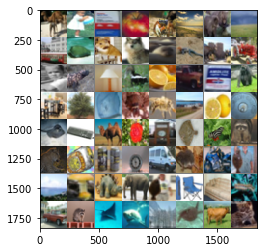

In [5]:
import torchvision
# Show some images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# # print labels
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
from alexnet import AlexNet

alexnet = AlexNet(100).to(device)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# I have use adam optimizer instead of SGD
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)
# optimizer = optim.SGD(alexnet.parameters(), lr=1e-2, momentum=0.9)

In [8]:
import os.path

MODEL_PATH = './alexnet.pth'
# load model if exist
if os.path.isfile('filename.txt'):
    alexnet.load_state_dict(torch.load("./alexnet.pth"))
    

<All keys matched successfully>

In [12]:
import time 

for epoch in range(50):
    running_loss = 0.0
    print(len(train_loader))
    t0 = time.time()
    # Training
    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
#         if i % 100 == 99:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / (100)))
#             running_loss = 0.000
            
    # Finding validation loss
    val_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
        
        t1 = time.time()
        total = t1-t0
        print(f"Epoch {epoch + 1}, Validation Loss: {val_loss/(val_size/BATCH_SIZE)}, time taken: {total}")
            
        
print("finished")

625
Epoch 1, Validation Loss: 2.71166427154541, time taken: 218.7083704471588
625
Epoch 2, Validation Loss: 2.674312875366211, time taken: 219.94576048851013
625
Epoch 3, Validation Loss: 2.657612589263916, time taken: 220.9697277545929
625
Epoch 4, Validation Loss: 2.689191530609131, time taken: 223.19207882881165
625
Epoch 5, Validation Loss: 2.6887403663635254, time taken: 221.65318965911865
625
Epoch 6, Validation Loss: 2.692382223510742, time taken: 222.06360507011414
625
Epoch 7, Validation Loss: 2.702255423736572, time taken: 211.62651085853577
625
Epoch 8, Validation Loss: 2.676753525543213, time taken: 207.46399760246277
625
Epoch 9, Validation Loss: 2.7083815292358397, time taken: 210.21502089500427
625
Epoch 10, Validation Loss: 2.7015293731689454, time taken: 207.59602904319763
625
Epoch 11, Validation Loss: 2.722436985015869, time taken: 204.34251070022583
625
Epoch 12, Validation Loss: 2.744791619873047, time taken: 203.7365095615387
625
Epoch 13, Validation Loss: 2.74045

KeyboardInterrupt: 

In [13]:
# Save model
torch.save(alexnet.state_dict(), MODEL_PATH)

finished


In [9]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        batch_size, n_crops, c, h, w = images.size()
        images = images.view(-1, c, h, w).to(device)
        labels = labels.to(device)
#         images = images.to(device)
#         labels = labels.to(device)

        outputs = alexnet(images)
        outputs = outputs.view(batch_size, n_crops, -1).mean(1)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 51 %
